In [1]:
import pickle
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from vit_pytorch import ViT

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <59ED1CF5-3CD8-3592-A70B-3AB98E4C5F21> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
sampling_rate = 200 # Hz
window_length = sampling_rate # 1 second
overlap = 0

## MyoArmband Dataset

In [3]:
def get_raw_dataset(eval_path):
    person_folders = os.listdir(eval_path)

    first_folder = os.listdir(eval_path)[0]
    keys = next(os.walk((eval_path+first_folder)))[1]

    number_of_classes = 7
    size_non_overlap = window_length - overlap

    raw_dataset_dict = {}
    for key in keys:
            
        raw_dataset = {
            'examples': [],
            'labels': [],
        }
        list_dataset = []
        list_labels = []
        for person_dir in person_folders:
            examples = []
            labels = []
            data_path = eval_path + person_dir + '/' + key
            for data_file in os.listdir(data_path):
                if (data_file.endswith(".dat")):
                    data_read_from_file = np.fromfile((data_path+'/'+data_file), dtype=np.int16)
                    data_read_from_file = np.array(data_read_from_file, dtype=np.float32)

                    dataset_example_formatted = []
                    example = []
                    emg_vector = []
                    for value in data_read_from_file:
                        emg_vector.append(value)
                        if (len(emg_vector) >= 8):
                            if (example == []):
                                example = emg_vector
                            else:
                                example = np.row_stack((example, emg_vector))
                            emg_vector = []
                            if (len(example) >= window_length):
                                example = example.transpose()
                                dataset_example_formatted.append(example)
                                example = example.transpose()
                                example = example[size_non_overlap:]
                    dataset_example_formatted = np.array(dataset_example_formatted)
                    examples.append(dataset_example_formatted)
                    data_file_index = int(data_file.split('classe_')[1][:-4])
                    label = data_file_index % number_of_classes + np.zeros(dataset_example_formatted.shape[0])
                    labels.append(label)

            raw_dataset['examples'].append(np.concatenate(examples))
            raw_dataset['labels'].append(np.concatenate(labels))

        raw_dataset_dict[key] = raw_dataset

    return raw_dataset_dict

In [4]:
train_path = 'datasets/MyoArmbandDataset/PreTrainingDataset/'
eval_path = 'datasets/MyoArmbandDataset/EvaluationDataset/'

eval_raw_dataset_dict = get_raw_dataset(eval_path)
train_raw_dataset_dict = get_raw_dataset(train_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_40153/2355956401.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [5]:
mad_all_windows = eval_raw_dataset_dict['training0']['examples'] + \
                    eval_raw_dataset_dict['Test0']['examples'] + \
                    eval_raw_dataset_dict['Test1']['examples'] + \
                    train_raw_dataset_dict['training0']['examples']

mad_all_labels = eval_raw_dataset_dict['training0']['labels'] + \
                    eval_raw_dataset_dict['Test0']['labels'] + \
                    eval_raw_dataset_dict['Test1']['labels'] + \
                    train_raw_dataset_dict['training0']['labels']

In [6]:
# filter by labels
mad_windows = None
mad_labels = None
for mad_p_examples, mad_p_labels in zip(mad_all_windows, mad_all_labels):
    label_map = (mad_p_labels >= 0) & (mad_p_labels <= 4)
    mad_subject_windows = mad_p_examples[label_map]
    subject_labels = mad_p_labels[label_map]

    if mad_windows is None:
        mad_windows = mad_subject_windows
        mad_labels = subject_labels
    else:
        mad_windows = np.concatenate((mad_windows, mad_subject_windows))
        mad_labels = np.concatenate((mad_labels, subject_labels))

In [41]:
def labels_to_dof(label):
    label_to_dof_map = {
        0: np.array([0.,0.]), # neutral
        1: np.array([0.,-1.]), # back
        2: np.array([-1.,0.]), # left
        3: np.array([0.,1.]), # forth
        4: np.array([1.,0.]), # right
    }
    return label_to_dof_map[label]

In [42]:
mad_dof_labels = np.array([labels_to_dof(label) for label in mad_labels])

## Nina Pro DB5

In [43]:
emg_min = -128.
emg_max = 127.
stride = window_length - overlap

In [44]:
def create_window_dataset(X, y, desired_labels = None):
    features_dataset = {key: [] for key in np.unique(y)}
    last_class_idx = None
    consequetive_features = []

    for class_idx, feature in zip(y, X):
        if class_idx != last_class_idx:
            if consequetive_features:
                features_dataset[class_idx].append(np.array(consequetive_features))
            consequetive_features = [feature]
            last_class_idx = class_idx
        else:
            consequetive_features.append(feature)

    if consequetive_features:
        features_dataset[class_idx].append(np.array(consequetive_features))

    windows = []
    labels = []
    for class_idx, feature_list in features_dataset.items():
        if desired_labels is None or class_idx in desired_labels:
            for consequetive_features in feature_list:
                num_windows = (consequetive_features.shape[0] - window_length) // stride + 1
                for i in range(num_windows):
                    start = i * stride
                    end = start + window_length
                    window = consequetive_features[start:end, :]
                    windows.append(window)
                    labels.append(class_idx)

    return np.array(windows, dtype=np.float32), np.array(labels, dtype=int)

In [45]:
ninapro_windows = None
ninapro_labels = None

ninapro_base_dir = 'datasets/ninapro/DB5/'

ninapro_person_dirs = next(os.walk(ninapro_base_dir))[1]
for nina_person_dir in ninapro_person_dirs:
    subject_id = nina_person_dir[-1]
    files = os.listdir(ninapro_base_dir + nina_person_dir)
    for file in files:
        if file.endswith('E2_A1.mat'):
            print(file)
            filepath = ninapro_base_dir + nina_person_dir + '/' + file

            ninapro_s1 = loadmat(filepath)

            ninapro_s_x_raw = ninapro_s1['emg'][:, :8]
            ninapro_s_x = np.interp(ninapro_s_x_raw, (emg_min, emg_max), (-1, +1))
            ninapro_s_y = ninapro_s1['restimulus'].squeeze()

            subject_windows, subject_labels = create_window_dataset(X = ninapro_s_x, y = ninapro_s_y, desired_labels = [0,13,14,15,16])

            if ninapro_windows is None:
                ninapro_windows = subject_windows
                ninapro_labels = subject_labels
            else:
                ninapro_windows = np.concatenate((ninapro_windows, subject_windows))
                ninapro_labels = np.concatenate((ninapro_labels, subject_labels))

ninapro_windows = ninapro_windows.swapaxes(1,2)

# replace labels
label_map = {0: 0,
             13: 2,
             14: 4,
             15: 1,
             16: 3,
             }

ninapro_mapped_labels = np.vectorize(label_map.get)(ninapro_labels)
ninapro_dof_labels = np.array([labels_to_dof(label) for label in ninapro_mapped_labels])

S5_E2_A1.mat
S2_E2_A1.mat
S3_E2_A1.mat
S4_E2_A1.mat
S10_E2_A1.mat
S8_E2_A1.mat
S1_E2_A1.mat
S6_E2_A1.mat
S7_E2_A1.mat
S9_E2_A1.mat


In [46]:
np.unique(ninapro_dof_labels)

array([-1.,  0.,  1.])

## Build dataloader

In [47]:
ninapro_windows.shape, ninapro_dof_labels.shape

((4639, 8, 200), (4639, 2))

In [48]:
mad_windows.shape, mad_dof_labels.shape

((6548, 8, 200), (6548, 2))

In [49]:
# combine mad and ninapro data
windows = np.concatenate((mad_windows, ninapro_windows))
labels = np.concatenate((mad_dof_labels, ninapro_dof_labels))
n_labels = len(np.unique(labels))
windows.shape, labels.shape

((11187, 8, 200), (11187, 2))

In [50]:
train_x, test_x, train_y, test_y = train_test_split(windows, labels)

In [77]:
class CustomEMGDataset(Dataset):
    def __init__(self, x_samples, y_samples):
        self.x_samples = x_samples
        self.y_samples = y_samples

    def __len__(self):
        return len(self.x_samples)
    
    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x_samples[idx,:,:])
        y_tensor = torch.tensor(self.y_samples[idx]).type(torch.float32)
        return x_tensor, y_tensor

In [78]:
train_dataset = CustomEMGDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomEMGDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [80]:
x, y = next(iter(test_dataloader))

<AxesSubplot:>

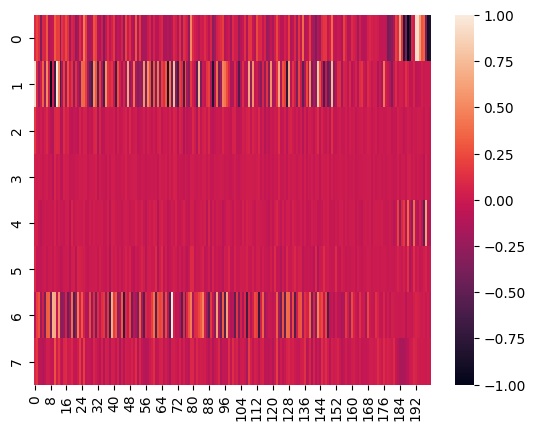

In [82]:
sns.heatmap(x[0,:,:])

## Train model

In [83]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

In [84]:
train_features, train_labels = next(iter(train_dataloader))

In [85]:
device = 'mps'
n_dof = 2

In [86]:
model = FFNN(200*8, 128, n_dof).to(device)

In [87]:
model(train_features.to(device)).shape

torch.Size([32, 2])

In [102]:
model = ViT(
    image_size = 200,
    patch_size = 8,
    num_classes = n_dof,
    dim = 64,
    depth = 1,
    heads = 2,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
).to(device) 

img = torch.randn(10, 1, 8, 200).to(device)

preds = model(img)

In [103]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
history = {
    'accs': [],
    'test_mse': [],
    'losses': [],
}

for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        model.train()

        train_inputs, train_labels = data
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        if model.__class__.__name__ == 'ViT':
            train_inputs.unsqueeze_(axis=1)

        optimizer.zero_grad()

        outputs = model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        history['losses'].append(loss.item())
        if i % 1000 == 999:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.8f}')
            running_loss = 0.0

    accs = []
    test_mse_list = []
    for data in test_dataloader:
        test_inputs, test_labels = data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        if model.__class__.__name__ == 'ViT':
            test_inputs.unsqueeze_(axis=1)
        model.eval()
        with torch.no_grad():
            outputs = model(test_inputs)
            # predicted_labels = outputs.cpu().max(dim=1).indices
            predicted_labels = outputs.cpu()

        test_labels = test_labels.cpu()
        # acc = accuracy_score(test_labels, predicted_labels)
        test_mse = mean_squared_error(test_labels, predicted_labels)
        # accs.append(acc)
        test_mse_list.append(test_mse)

    # history['accs'].append( np.mean(accs))
    history['test_mse'].append(np.mean(test_mse_list))

    print('test MSE', np.mean(test_mse_list))

print('Finished Training')

test MSE 0.21793383
test MSE 0.20713381
test MSE 0.20281285
test MSE 0.18854767
test MSE 0.1928003
test MSE 0.18920444
test MSE 0.18393499
test MSE 0.18257813
test MSE 0.18437292
test MSE 0.18409795
test MSE 0.18561979
test MSE 0.1746613
test MSE 0.17857842
test MSE 0.18062526
test MSE 0.17973033
test MSE 0.17754485
test MSE 0.1802259
test MSE 0.17592178
test MSE 0.17453818
test MSE 0.17800947
Finished Training


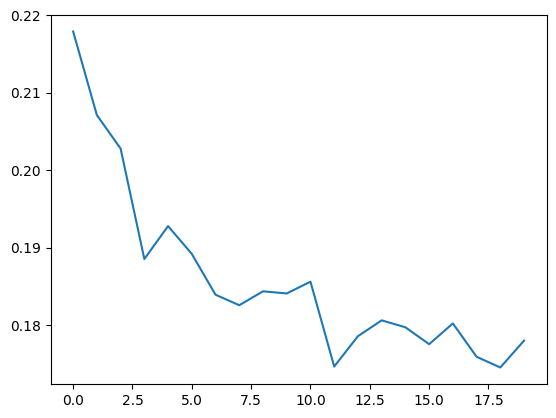

In [106]:
plt.plot(history['test_mse'])

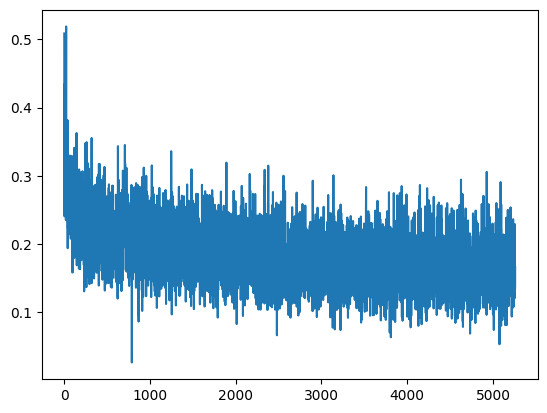

In [107]:
plt.plot(history['losses'])

In [108]:
single_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [109]:
dts = []
for data in single_test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    if model.__class__.__name__ == 'ViT':
        inputs.unsqueeze_(axis=1)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = outputs.cpu().max(dim=1).indices

    dt = time.time() - start_time
    dts.append(dt)

dts = np.array(dts)[1:]
1 / dts[1:].mean(), 'Hz'

(416.5998462539175, 'Hz')

In [110]:
torch.save(model.cpu(), 'models/pretained_vit_2dof.pt')

In [615]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'pretained_vit_state_dict.pt')

In [652]:
model_loaded = torch.load('pretained_vit_2.pt').to(device)

In [655]:
test_input = torch.randn(1,1,8,200).to(device)
model_loaded(test_input)

tensor([[ 0.0303, -1.2299,  0.7546, -1.1609, -0.4045]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [653]:
accs = []
for data in test_dataloader:
    test_inputs, test_labels = data
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)
    if model_loaded.__class__.__name__ == 'ViT':
        test_inputs.unsqueeze_(axis=1)
    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(test_inputs)
        predicted_labels = outputs.cpu().max(dim=1).indices

    test_labels = test_labels.cpu()
    acc = accuracy_score(test_labels, predicted_labels)
    accs.append(acc)

history['accs'].append( np.mean(accs))
print('test accuracy', np.mean(accs))

test accuracy 0.6832932692307693


# Transfer learning

**TODO**
Try if this improves performance

https://github.com/KevinMusgrave/pytorch-adapt/blob/main/examples/getting_started/PaperImplementationsAsHooks.ipynb

In [ ]:
import copy
from pprint import pprint

import torch

from pytorch_adapt.hooks import MCDHook
from pytorch_adapt.layers import MultipleModels, SlicedWasserstein
from pytorch_adapt.utils import common_functions as c_f

In [23]:
# Models
# Encoder
G = torch.nn.Linear(1000, 100)
# CLassification head
C = torch.nn.Linear(100, 10)

D = torch.nn.Sequential(torch.nn.Linear(100, 1), torch.nn.Flatten(start_dim=0))
G_opt = torch.optim.Adam(G.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

dataset_size = 10000
# 1 batch of data
example_data = {
    "src_imgs": torch.randn(32, 1000),
    "target_imgs": torch.randn(32, 1000),
    "src_labels": torch.randint(0, 10, size=(32,)),
    "src_domain": torch.zeros(32),
    "target_domain": torch.zeros(32),
    "src_sample_idx": torch.randint(0, dataset_size, size=(32,)),
    "target_sample_idx": torch.randint(0, dataset_size, size=(32,)),
}


def get_data(keys):
    return {k: example_data[k] for k in keys}

In [50]:
# MCD needs 2 classifiers
C_ = MultipleModels(C, c_f.reinit(copy.deepcopy(C)))
C_opt_ = torch.optim.Adam(C_.parameters())
loss_fn = SlicedWasserstein(m=128)

hook = MCDHook(g_opts=[G_opt], c_opts=[C_opt_], discrepancy_loss_fn=loss_fn)

models = {"G": G, "C": C_}
data = get_data(["src_imgs", "target_imgs", "src_labels"])
_, losses = hook({**models, **data})
pprint(losses)

{'x_loss': {'src_c_loss0': 0.006591843441128731,
            'src_c_loss1': 2.502946615219116,
            'total': 1.254769206047058},
 'y_loss': {'discrepancy_loss': -0.4307219982147217,
            'src_c_loss0': 0.005981766618788242,
            'src_c_loss1': 2.2412302494049072,
            'total': 0.6054966449737549},
 'z_loss': {'discrepancy_loss': 0.2203170657157898,
            'total': 0.2203170657157898}}
